# CYCLOPS on 12 Tissue Data

## 1. Importing packages

In [1]:
from cyclops_v2 import *
from spca import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

In [2]:
df = pd.read_csv("circadian_12tissue_data.csv").T

#### Choose the tissue to investigate:

In [3]:
tissue = 'Liv'

#### Print gene expression dataframe:

In [4]:
df = df[df.index.str.contains(tissue)]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,23033,23034,23035,23036,23037,23038,23039,23040,23041,23042
Liv_CT18,9.97596,4.11196,6.28843,5.80939,4.74895,12.3252,9.3497,6.60504,7.30602,7.64396,...,4.62135,5.81757,10.4864,4.64678,4.97498,6.84226,4.61643,4.99553,4.41443,6.43902
Liv_CT20,9.95559,4.11114,6.2368,5.93797,4.87801,12.3077,9.21748,6.80207,7.18151,7.75016,...,4.47124,5.7651,10.7786,4.59516,4.90173,6.93262,4.59902,5.06052,4.25985,6.2893
Liv_CT22,9.98907,4.16358,6.38042,5.97262,4.72044,12.3138,9.1118,6.55709,7.01842,7.71125,...,4.47167,5.84639,10.7554,4.65096,4.81977,6.7802,4.54498,5.08509,4.51375,6.3185
Liv_CT24,10.0697,4.19457,6.33788,5.70987,4.78963,12.3235,9.15773,6.79351,7.46828,7.89416,...,4.45783,5.74145,10.6536,4.60124,4.98461,6.72523,4.57095,4.99013,4.51414,6.1766
Liv_CT26,9.83033,4.10665,6.56977,6.03469,4.73067,12.3106,9.17727,6.462,7.24255,7.86156,...,4.54193,5.78536,10.8425,4.58357,4.76532,6.73776,4.53446,5.05956,4.52692,6.46509


In [5]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 23043 genes and 24 cells.


## 3. Data Preprocessing

Filter and sort genes in descending order of variance:

In [6]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23043 entries, 21369 to 17114
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23043 non-null  float64
dtypes: float64(1)
memory usage: 360.0 KB


In [7]:
gene_list = df_std.index.to_numpy()
gene_list;

In [8]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(24, 23043)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [9]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,23033,23034,23035,23036,23037,23038,23039,23040,23041,23042
0,2.641105,2.558519,2.150665,-0.367454,2.450458,1.791712,2.627910,-1.700455,-1.025457,2.489283,...,0.035785,-0.003253,-0.005399,0.011644,-0.036814,0.011958,0.005163,0.008489,-0.019797,0.031333
1,1.207999,1.016322,0.353066,-1.370228,-0.168146,0.618631,0.590937,-1.667805,1.224555,-0.080810,...,-0.015999,0.012795,0.003529,-0.003382,-0.003784,-0.030124,0.028806,0.012200,-0.007773,0.004421
2,2.701630,2.639071,2.298488,-2.371649,-0.301123,1.900822,-0.644160,-1.354648,2.135806,2.750692,...,0.020504,0.028662,0.003850,-0.000332,0.010537,0.031443,-0.017195,0.029938,0.003701,-0.021288
3,2.110941,2.005698,1.509396,-2.508211,-1.306045,1.364631,-1.652177,-0.426139,2.425985,1.641433,...,0.035496,0.054621,0.004227,0.057028,0.014449,-0.015495,0.006982,0.003367,0.022370,0.029242
4,1.572013,1.161898,0.936803,-2.097047,0.052680,1.058496,-0.007061,1.396402,1.753485,0.578517,...,0.007741,-0.052177,0.035770,-0.030426,0.019756,-0.006081,-0.021310,-0.021304,-0.008549,-0.009813


## Sparse PCA

#### Perform sparse principal component analysis (SPCA)

First, convert the dataframe into a numpy array:

In [10]:
data_ = df_cent.to_numpy()

#### Perform Karthik's Sparse PCA, choosing appropriate values for alpha (sparsity parameter) and n_components (rank):

In [11]:
n_components = 9
alpha = 8
test = rank_n_o(data_, t=alpha, tol=10e-4, rank=n_components)

In [12]:
for k, v in test.items():
    if k=='XV':
        spca_eigengenes = pd.DataFrame(v)
    if k=='V':
        loading_vectors = pd.DataFrame(v)

#### Loading vectors:

In [13]:
loading_vectors = loading_vectors[(loading_vectors.select_dtypes(include=['number']) != 0).any(1)]
loading_vectors.head()

,0,1,2,3,4,5,6,7,8
0,-0.407714,0.102158,0.000000,0.000000,-0.407538,0.006240,0.0,0.0,0.000000
1,-0.349945,0.000000,0.000000,0.000000,-0.272855,0.000000,0.0,0.0,-0.040335
2,-0.274810,0.000000,0.000000,0.000000,-0.206421,0.000000,0.0,0.0,0.000000
3,0.259762,0.000000,0.080704,0.000000,-0.214560,0.000000,0.0,0.0,-0.004661
4,0.000000,0.000000,0.306700,0.552818,0.000000,0.035989,0.0,0.0,0.000000


#### Eigengenes:

In [14]:
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,-6.139882,-2.448010,5.504718,1.292303,-2.460754,3.704058,-0.529135,-0.697274,-0.125655
1,-5.345238,-4.872050,1.382557,-0.625043,1.406575,1.120865,-0.242349,-2.496159,-1.029682
2,-9.369291,-1.598668,-0.294014,0.667825,1.419297,-2.917788,1.452469,-1.591479,-4.020247
3,-8.655485,-5.317890,-1.837321,-2.775706,1.915980,-1.193752,-0.034070,4.247001,0.367446
4,-6.010037,-1.046262,-3.796230,3.139607,2.580174,-1.637110,-2.501559,-2.232965,0.210775


__Clip__ the values in each eigengene to deal with outliers:

In [15]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,-6.139882,-2.448010,5.474868,1.292303,-2.460754,3.704058,-0.529135,-0.697274,-0.125655
1,-5.345238,-4.872050,1.382557,-0.625043,1.406575,1.120865,-0.242349,-2.456680,-1.029682
2,-8.626049,-1.598668,-0.294014,0.667825,1.419297,-2.853166,1.452469,-1.591479,-2.202012
3,-8.626049,-4.983118,-1.837321,-2.775706,1.915980,-1.193752,-0.034070,3.958734,0.367446
4,-6.010037,-1.046262,-3.796230,3.139607,2.580174,-1.637110,-2.501559,-2.232965,0.210775


Sort the eigengenes in descending order of variance:

In [16]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([0, 2, 1, 3, 5, 4, 7, 6, 8])

Reorder the columns of the dataframe in descending order of variance:

In [17]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

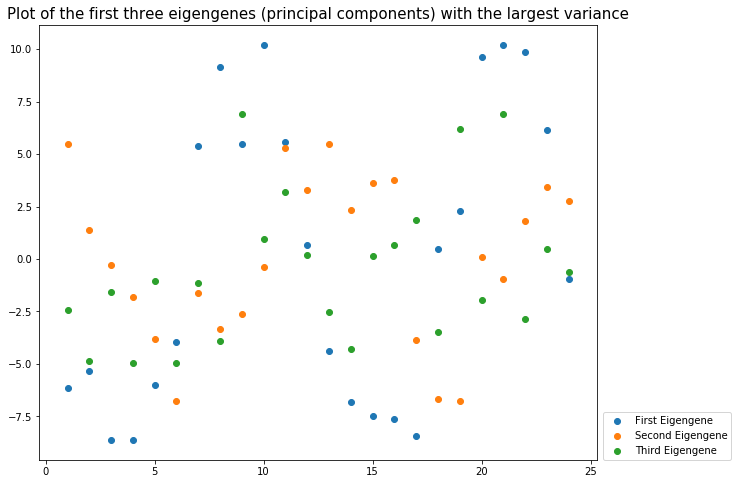

In [18]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

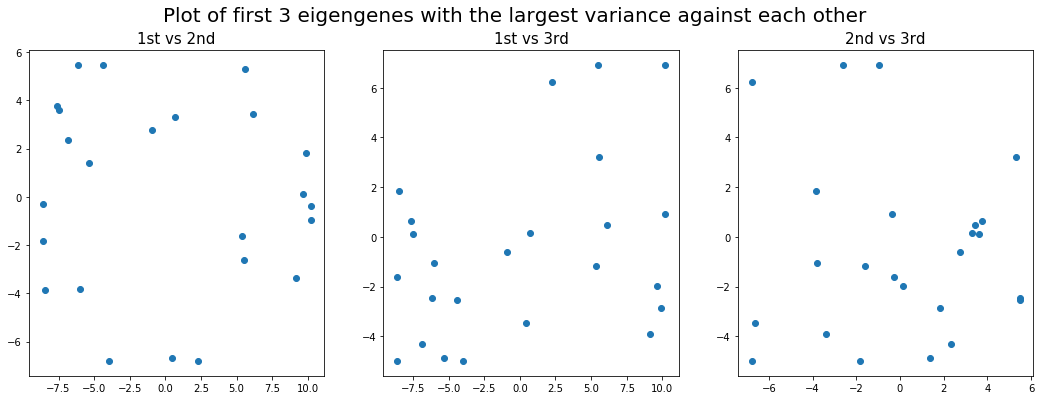

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [20]:
data = spca_eigengenes.to_numpy()

In [21]:
model = cyclops(data.shape[1])
model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 9)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 9)            0           input_layer[0][0]                
__________________________________________________________________________________________________
hidden_input (Dense)            (None, 5)            50          dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5)            0           hidden_input[0][0]               
_______________________________________________________________________________________

### Train the model:

In [22]:
history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=300, verbose=50, batch_size=10)

epoch: 50/300, loss: -0.5816, time elapsed:  0.86s, time left:  4.31s
epoch: 100/300, loss: -0.5080, time elapsed:  1.05s, time left:  2.11s
epoch: 150/300, loss: -0.6240, time elapsed:  1.25s, time left:  1.25s
epoch: 200/300, loss: -0.4902, time elapsed:  1.42s, time left:  0.71s
epoch: 250/300, loss: -0.7268, time elapsed:  1.61s, time left:  0.32s
epoch: 300/300, loss: -0.6263, time elapsed:  1.80s, time left:  0.00s


#### Plot the loss of the model to check if it has converged:

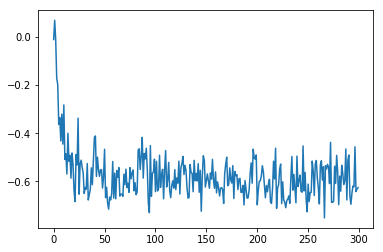

In [23]:
plt.plot(history.history['loss'])

## 5. Results and analysis

Print a dataframe of phase values generated from the autoencoder, and sort the rows according to increasing pseudotime values:

In [24]:
phase_df = model.phase_output(data)
phase_df.head()

,pseudotime
3,-3.084205
2,-2.849639
16,-2.770231
4,-2.353725
5,-2.107712


#### $z_p$ and $z_q$ are the values of each circular node in the bottleneck layer, from which the pseudotime (phase) values were extracted using argtan operations.

Next, print the lists of indices (which are the sample collection times) and phase values:

In [25]:
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()
phase_idx, phase_list

(array([ 3,  2, 16,  4,  5, 17,  6, 18,  7,  8, 19, 20,  9, 21, 10, 22, 11,
        23, 12,  0, 13, 15, 14,  1]),
 array([-3.0842052 , -2.8496392 , -2.7702315 , -2.353725  , -2.107712  ,
        -1.3695747 , -1.0187117 , -0.7264116 , -0.11872853, -0.10140163,
         0.05505519,  0.1484127 ,  0.29701477,  0.49806643,  0.8261693 ,
         1.0477934 ,  1.6077032 ,  1.8229718 ,  2.6709218 ,  2.8084202 ,
         2.9256682 ,  3.0360956 ,  3.0560086 ,  3.1384017 ], dtype=float32))

### Plotting

Produce a polar plot of phase values:

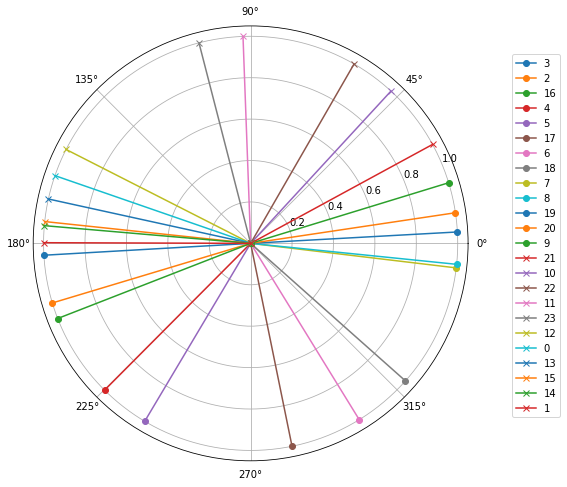

In [26]:
model.plot_polar(nc, phase_idx, phase_list)

#### Adjust and wrap phase values such that the phase at the first collection time (time 0) is zero:

In [27]:
idx = list(phase_idx).index(0)
phase_list -= phase_list[idx]

for i in range(len(phase_list)):
    if phase_list[i] > np.pi:
        phase_list[i] = -np.pi + (phase_list[i]-np.pi)
    elif phase_list[i] < -np.pi:
        phase_list[i] = np.pi - (-np.pi-phase_list[i])
        
phase_list

array([ 0.39055997,  0.6251262 ,  0.7045339 ,  1.1210402 ,  1.3670534 ,
        2.1051905 ,  2.4560535 ,  2.7483535 , -2.9271488 , -2.9098217 ,
       -2.753365  , -2.6600075 , -2.5114055 , -2.3103538 , -1.9822509 ,
       -1.7606268 , -1.200717  , -0.98544836, -0.13749838,  0.        ,
        0.11724806,  0.22767544,  0.2475884 ,  0.32998157], dtype=float32)

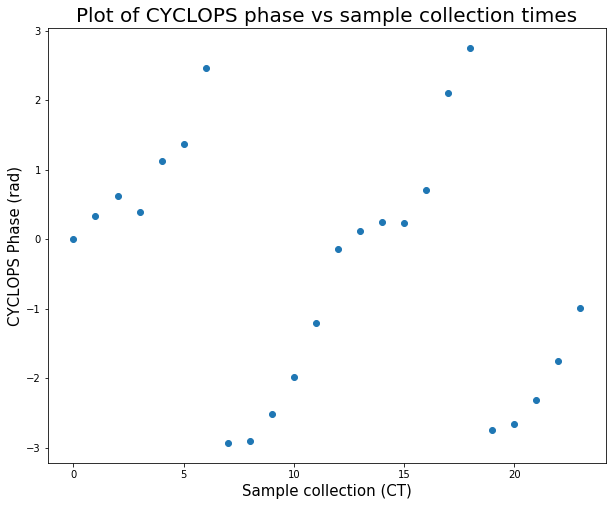

In [28]:
model.plot_phase_time(phase_idx, phase_list)

### Remapping

Create a dictionary of remapped sample indices according to increasing phase values:

In [29]:
remap_dict = model.remap(nc,phase_idx)

### Processing

#### Re-ordering the samples from the original dataset:

In [30]:
ori = df.to_numpy().T

new = np.zeros([ng,nc])
for i in range(ng):
    for key, val in remap_dict.items():
        new[i][val-1] = ori[i][key-1]

In [31]:
new.shape

(23043, 24)

#### Define a sinusoidal function to fit the reordered gene expressions. The function takes 4 parameters: intercept, amplitude, frequency and phase difference:

In [32]:
def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.sin(omega * x + phi)

#### Create a curve fitting function that fits an optimal sinusoid to expression data for every gene:

In [33]:
from scipy import optimize
def fit_(f, xdata, ydata):
    try:
        popt, pcov = optimize.curve_fit(f, xdata, ydata)

        #Residual sum of squares (ss_res):
        residuals = ydata- f(xdata, *popt)
        ss_res = np.sum(residuals**2)

        #Total sum of squares (ss_tot):
        ss_tot = np.sum((ydata-np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)   
            
        return popt, pcov, r_squared

    except:
        pass

#### Store the parameter, covariance and $R^2$ values in arrays:

In [34]:
%%time

params, pcov = np.zeros([ng,4]), np.zeros([ng,4,4])
r_squared = np.zeros(ng)

for i in range(ng):
    try:
        params[i] = fit_(test_func, phase_list, new[i])[0]
        pcov[i] = fit_(test_func, phase_list, new[i])[1]
        r_squared[i] = fit_(test_func, phase_list, new[i])[2]
    except:
        continue

CPU times: user 3min 52s, sys: 1.52 s, total: 3min 53s
Wall time: 3min 58s


In [35]:
params.shape, pcov.shape, r_squared.shape

((23043, 4), (23043, 4, 4), (23043,))

####  Create a dataframe of parameter and $R^2$ values and print:

_Note: if optimal parameters cannot be found for a particular gene, the parameter and $R^2$ values will be zero._

In [36]:
df_params = pd.DataFrame(params, columns=['intercept', 'amplitude', 'frequency', 'phase_shift'])
df_params['r_squared'] = r_squared

Sort the dataframe in descending order of $R^2$ values:

In [37]:
df_params = df_params.sort_values(by='r_squared', ascending = False)
df_params.head()

,intercept,amplitude,frequency,phase_shift,r_squared
15309,7.133506,1.585980,0.772534,1.508324,0.974875
8864,3.389146,5.677044,0.290889,1.585985,0.974582
5259,9.363073,0.740407,0.762113,1.249222,0.967297
4589,8.796903,1.562106,0.679245,1.456693,0.962574
5803,11.069625,0.407642,0.645655,1.309705,0.958080


#### Plot the expression for the top 9 genes with the highest $R^2$ values:

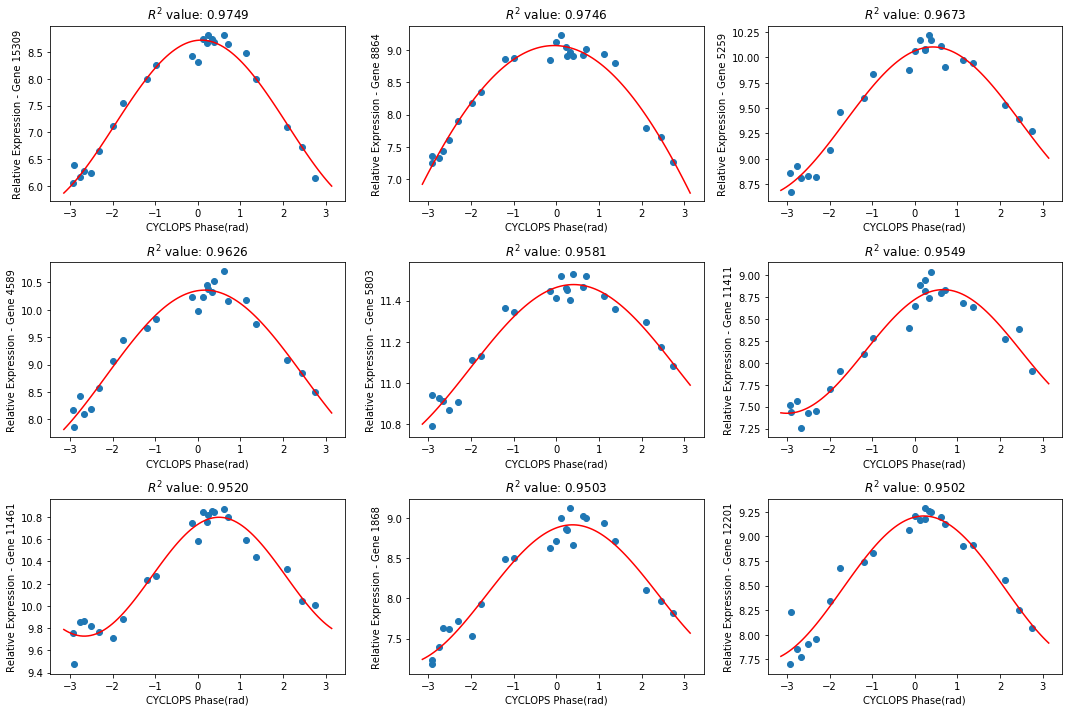

In [38]:
x = np.linspace(-np.pi,np.pi,100)

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(phase_list, new[df_params.index[i]])
    plt.plot(x, df_params.intercept.iloc[i]+df_params.amplitude.iloc[i]*np.sin(df_params.frequency.iloc[i]*x+df_params.phase_shift.iloc[i]), c='red')        
    plt.xlabel('CYCLOPS Phase(rad)')
    plt.ylabel('Relative Expression - Gene {}'.format(df_params.index[i]))
    plt.title('$R^2$ value: {:.4f}'.format(df_params.r_squared.iloc[i]))
    plt.tight_layout()

### Evaluating fit using R^2 values

#### Print the collection time indices reordered according to increasing index collection time values:

In [39]:
phase_df = model.phase_output(data)
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()

re_phase_idx = phase_df.sort_index().index.to_numpy()
re_phase_list = phase_df.sort_index()['pseudotime'].to_numpy()

re_phase_idx, re_phase_list

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([ 2.8084202 ,  3.1384017 , -2.8496392 , -3.0842052 , -2.353725  ,
        -2.107712  , -1.0187117 , -0.11872853, -0.10140163,  0.29701477,
         0.8261693 ,  1.6077032 ,  2.6709218 ,  2.9256682 ,  3.0560086 ,
         3.0360956 , -2.7702315 , -1.3695747 , -0.7264116 ,  0.05505519,
         0.1484127 ,  0.49806643,  1.0477934 ,  1.8229718 ], dtype=float32))

#### Determine the indices of phase jumps (in either direction) of absolute value greater than pi:

In [40]:
asc_phase_jump, desc_phase_jump = [],[]
for i in range(len(re_phase_list)-1):
    if re_phase_list[i+1]-re_phase_list[i] > np.pi:
        desc_phase_jump.append(i)
    elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
        asc_phase_jump.append(i)
        
asc_phase_jump, desc_phase_jump

([1, 15], [])

#### Function to remove anomalous jumps caused by noise in reorderings:

In [41]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    
    margin = 10
    for i in range(1,len(X)):
        if X[i]-X[i-1]<margin:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

In [42]:
if len(asc_phase_jump) > len(desc_phase_jump):
    phase_jump = asc_phase_jump
else:
    phase_jump = desc_phase_jump
    

phase_jump = jump_control(phase_jump)
phase_jump 

[1, 15]

#### Phase plots with red markers for identified jumps:

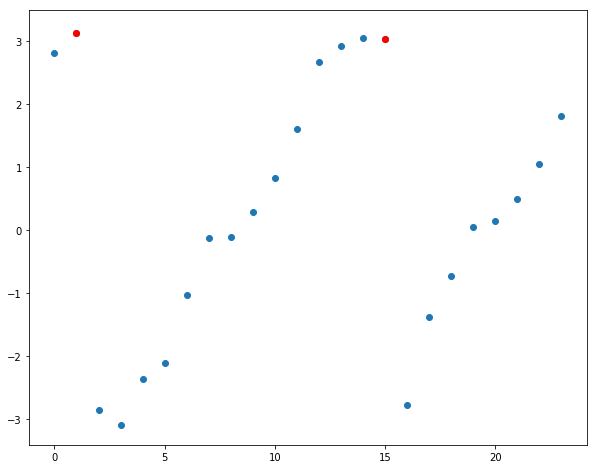

In [43]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.scatter(re_phase_idx[phase_jump], re_phase_list[phase_jump], marker='o', color="red")
plt.show()

#### Increment or decrement values in the phase list by 2pi based on the sign of the phase jumps:

In [44]:
jumps = len(phase_jump)
for i in range(jumps):
    if len(asc_phase_jump) > len(desc_phase_jump):
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(nc)])
    else:
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(nc)])
    phase_jump.pop(0)

#### Linear regression:

In [45]:
from scipy.stats import linregress

lin = linregress(re_phase_idx, re_phase_list)
lin

LinregressResult(slope=0.522689325597661, intercept=2.1529861437359763, rvalue=0.9944601948603087, pvalue=5.064357693267046e-23, stderr=0.011778902237362979)

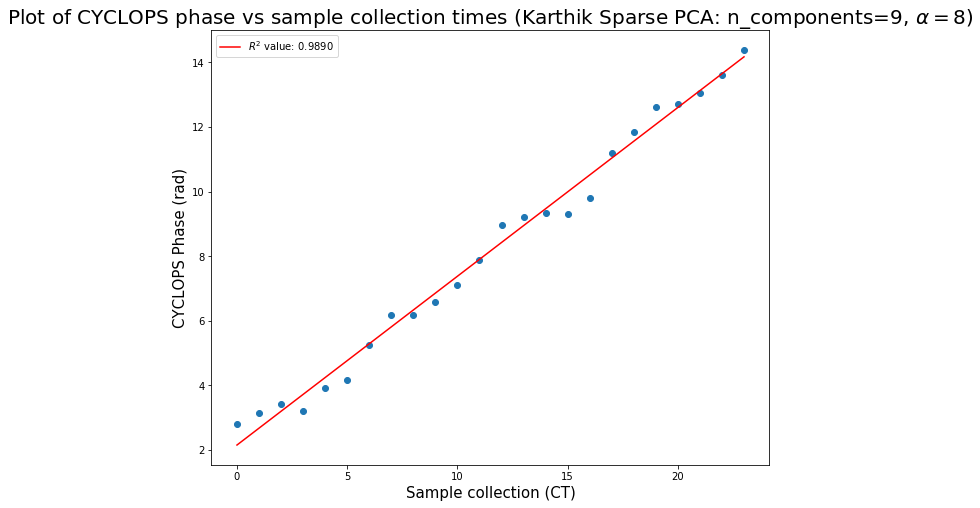

In [46]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.plot(re_phase_idx, lin[0]*re_phase_idx + lin[1], color='red', label='$R^2$ value: {:.4f}'.format(lin[2]**2))
plt.title(r'Plot of CYCLOPS phase vs sample collection times (Karthik Sparse PCA: n_components={}, $\alpha={}$)'.format(n_components, alpha), size=20)
plt.xlabel('Sample collection (CT)', size=15)
plt.ylabel('CYCLOPS Phase (rad)', size=15)
plt.legend()
plt.show()